In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

# Q1

In [ ]:
matrices = []
for k in range(5):
  true_k = k+1
  matrices.append([])
  for i in range(10):
    true_i = i+1
    matrices[k].append([])
    for j in range(10):
      true_j = j+1
      if true_i < true_j:
        value = np.exp(true_i/true_j) * np.cos(true_i*true_j) * np.sin(true_k)
      elif true_i > true_j:
        value = matrices[k][j][i]
      else:
        value = 0
      matrices[k][i].append(value)

  for d in range(10):
    true_d = d + 1
    sum = 0
    for l in range(10):
      if l != d:
        sum += np.abs(matrices[k][d][l])
    value = (true_d/10) * np.abs(np.sin(true_k)) + sum
    matrices[k][d][d] = value

  matrices[k] = np.array(matrices[k])

vectors = []
for k in range(5):
  vectors.append([])
  for i in range(10):
    true_i = i+1
    true_k = k+1
    vectors[k].append(np.exp(true_i/true_k) * np.sin(true_i*true_k))

In [ ]:
x1 = np.ones(10)

for k in range(5):
  print(np.dot(x1, matrices[k] @ x1) - np.dot(x1, vectors[k]))


5337.066429311362
12.104221222535315
29.4798349941795
78.82665877069525
101.1388127109267


Level Method

In [ ]:
def pointwise_max_subgradient(functions, matrices, vectors, x):
  i = np.argmax([f(x) for f in functions])
  gradient = 2 * matrices[i] @ x - vectors[i]
  
  return gradient

def pointwise_max_eval(functions, x):
  return max([f(x) for f in functions])

def pointwise_max_f(functions):
  return lambda x, functions=functions : max([f(x) for f in functions])


In [ ]:
T = 100
xs = [np.ones(10)]
f_obj = [lambda x, matrices=matrices, vectors=vectors, k=k: np.dot(x, matrices[k] @ x) - np.dot(x, vectors[k]) for k in range(5)]
f = []
lam = 0.9


x = cvx.Variable(10)
t = cvx.Variable()
G = [-5 <= x, x <= 5]

losses = []
min_so_far = 1e10

for i in range(T):
  x_curr = xs[-1]
  g = pointwise_max_subgradient(f_obj, matrices, vectors, x_curr)
  f_curr = pointwise_max_eval(f_obj, x_curr) + g @ (x - x_curr)
  f.append(f_curr)

  f_i_minus_prob = cvx.Problem(cvx.Minimize(t), constraints=[t >= f_i for f_i in f] + G)

  f_i_minus = f_i_minus_prob.solve()

  f_i_plus = min([pointwise_max_f(f_obj)(x_i) for x_i in xs])

  l = (1 - lam) * f_i_minus + lam * f_i_plus

  x_next_prob = cvx.Problem(cvx.Minimize(cvx.norm2(x_curr - x)), constraints = [l >= f_i for f_i in f] + G)

  result = x_next_prob.solve()

  x_next = np.array(x.value)

  xs.append(x_next)
  # print("x next:", x_next)

  eval = pointwise_max_eval(f_obj, x_next)

  min_so_far = min(min_so_far, eval)

  losses.append(min_so_far)

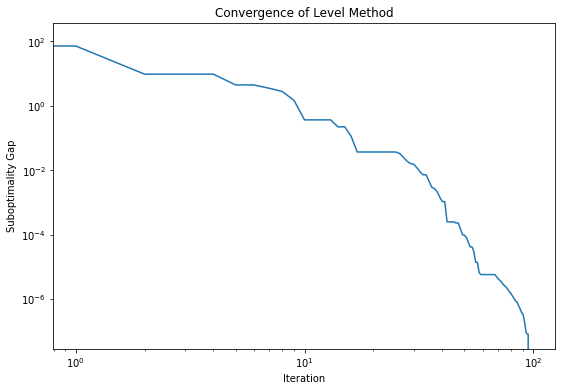

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(T), np.array(losses) - min(losses))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Suboptimality Gap')
ax.set_xlabel('Iteration')
ax.set_title('Convergence of Level Method')
plt.show()

# Q2

In [ ]:
n = 20
A = np.random.normal(size=(n,n))
A = np.zeros(shape=(n,n))
A[0][0] = 2
A[0][1] = -1
A[n-1][n-2] = -1
A[n-1][n-1] = 2
for i in range(1, n-1):
  A[i][i-1] = -1
  A[i][i] = 2
  A[i][i+1] = -1

In [ ]:
xs = [np.ones(n)]
T = 100000
a = 0.02
losses_gd = []
min_so_far = 1e10
for i in range(T):
  x_curr = xs[-1]
  x_next = x_curr - a * (A.T @ A) @ x_curr
  xs.append(x_next)

  eval = x_next.T @ A.T @ A @ x_next
  min_so_far = min(eval, min_so_far)
  losses_gd.append(min_so_far)

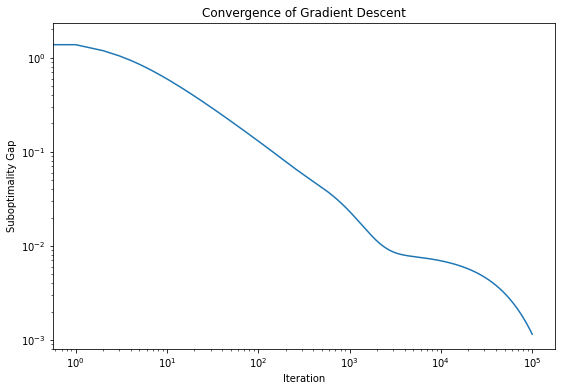

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(T), np.array(losses_gd))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Suboptimality Gap')
ax.set_xlabel('Iteration')
ax.set_title('Convergence of Gradient Descent')
plt.show()

In [ ]:
xs = [np.ones(n)]
T = 100000
losses_agd = []
lam = 1
gamma = 0
a = 0.02
z = np.ones(n)
min_so_far = 1e10

for i in range(T):
  x_curr = xs[-1]
  y = (1 - gamma) * x_curr + gamma * z
  z = z - a * (gamma/lam) * (A.T @ A) @ y
  x_next = y - a * (A.T @ A) @ y
  xs.append(x_next)
  if i > 3:
    gamma = 2/i
    lam = 6/(i**2 - i)

  eval = x_next.T @ A.T @ A @ x_next
  min_so_far = min(min_so_far, eval)
  losses_agd.append(min_so_far)

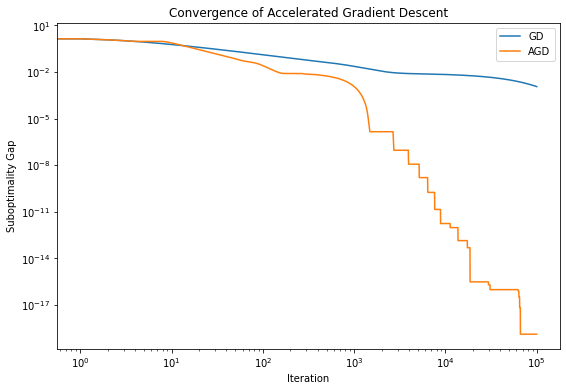

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(T), np.array(losses_gd), label="GD")
ax.plot(np.arange(T), np.array(losses_agd), label="AGD")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Suboptimality Gap')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Convergence of Accelerated Gradient Descent')
plt.show()